# Import

In [127]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
#import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#import the data
data_features_train = pd.read_csv('train_features.csv',index_col='pid').sort_values(by=['pid', 'Time'])
data_features_test = pd.read_csv('test_features.csv',index_col='pid').sort_values(by=['pid', 'Time'])
data_labels_train = pd.read_csv('train_labels.csv', index_col='pid').sort_values(by=['pid'])


vitals = ['LABEL_RRate', 'LABEL_ABPm', 'LABEL_SpO2', 'LABEL_Heartrate']
tests = ['LABEL_BaseExcess', 'LABEL_Fibrinogen', 'LABEL_AST', 'LABEL_Alkalinephos', 'LABEL_Bilirubin_total',
         'LABEL_Lactate', 'LABEL_TroponinI', 'LABEL_SaO2',
         'LABEL_Bilirubin_direct', 'LABEL_EtCO2']
sepsis = ['LABEL_Sepsis']

# Preprocessing the data for Subtask 1&2

In [129]:
def feature_engineering(df):
    df_pop_mean = df.drop(['Age'], axis=1).mean()
    #construct the features
    
    df_age = df['Age'].groupby(by='pid', dropna=False).mean() #this is a bit hackerboy method lmao
    
    df_mean = df.drop(['Age'], axis=1).groupby(by='pid', dropna=False).mean()
    df_var = df.drop(['Age'], axis=1).groupby(by='pid', dropna=False).var()
    df_min = df.drop(['Age'], axis=1).groupby(by='pid', dropna=False).min()
    df_max = df.drop(['Age'], axis=1).groupby(by='pid', dropna=False).max()
    df_first = df.drop(['Age'], axis=1).groupby(by='pid', dropna=False).first()
    df_last = df.drop(['Age'], axis=1).groupby(by='pid', dropna=False).last()
    df_nan_count = df.drop(['Age'], axis=1).groupby(by='pid', dropna=False).count()
    #df_last_observed_value = df.groupby(by='pid', dropna=False)
    #df_first_observed_value
    
    
    
    #impute missing values
    df_mean.fillna({col:df_pop_mean[col] for col in df.drop(['Age'], axis=1).columns}, inplace=True)
    df_var.fillna({col:df_pop_mean[col] for col in df.drop(['Age'], axis=1).columns}, inplace=True)
    df_min.fillna({col:df_pop_mean[col] for col in df.drop(['Age'], axis=1).columns}, inplace=True)
    df_max.fillna({col:df_pop_mean[col] for col in df.drop(['Age'], axis=1).columns}, inplace=True)
    df_first.fillna({col:df_pop_mean[col] for col in df.drop(['Age'], axis=1).columns}, inplace=True)
    df_last.fillna({col:df_pop_mean[col] for col in df.drop(['Age'], axis=1).columns}, inplace=True)
    #df_last_observed_value.fillna({col:df_pop_mean[col] for col in df.drop(['Age'], axis=1).columns}, inplace=True)
    #df_first_observed_value.fillna({col:df_pop_mean[col] for col in df.drop(['Age'], axis=1).columns}, inplace=True)
    
    df_features = pd.concat([df_age, df_mean.add_suffix('_mean'), df_var.add_suffix('_var'),
                             df_min.add_suffix('_min'), df_max.add_suffix('_max'), df_first.add_suffix('_first'),
                             df_last.add_suffix('_last'), df_nan_count.add_suffix('_nan_count')], axis=1)
    return df_features
    


# Subtask 3

In [130]:
#set up features, took most correlated ones for each of 'RRate', 'ABPm', 'SpO2', 'Heartrate'

features_3 = ['Age','Temp', 'Lactate', 'ABPs', 'Chloride', 'Hgb', 'pH', 'ABPd', 'RRate', 'ABPm', 'SpO2', 'Heartrate']

X_3_train = feature_engineering(data_features_train[features_3])
X_3_test = feature_engineering(data_features_test[features_3])
y_3_train = data_labels_train[vitals]

In [128]:
# Define a pipeline to search for the best hyperparameters for ridge/randomforest

pipe = Pipeline([('scaler', StandardScaler()), ('regr', RandomForestRegressor())])

# Parameter space:
max_features = ['sqrt']
n_estimators = [500,600,700,800]

param_grid = {'regr':[RandomForestRegressor()],
            'regr__max_features':max_features,
            'regr__n_estimators':n_estimators}

model = GridSearchCV(pipe, param_grid=param_grid, scoring='r2', verbose=50)

predictions = np.empty([data_features_test.index.unique().size,len(features_3)])
predictions.shape

best_scores = []
m = 0
for vital in vitals:

    model.fit(features_train, data_labels_train[vital])
    predictions[:,m] = model.predict(X_3_test) 
    best_scores.append(model.best_score_)
    

print(f'The mean r2-score is: {np.mean(best_scores)}')
submission_3 = pd.DataFrame(predictions, index=y_3_train.index, columns=y_3_train.columns)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START regr=RandomForestRegressor(), regr__max_features=sqrt, regr__n_estimators=500


KeyboardInterrupt: 

# Subtask 1

We want to predict the whether the following tests are ordered by a physician:

LABEL_BaseExcess, LABEL_Fibrinogen, LABEL_AST, LABEL_Alkalinephos, LABEL_Bilirubin_total, LABEL_Lactate, LABEL_TroponinI, LABEL_SaO2, LABEL_Bilirubin_direct, LABEL_EtCO2


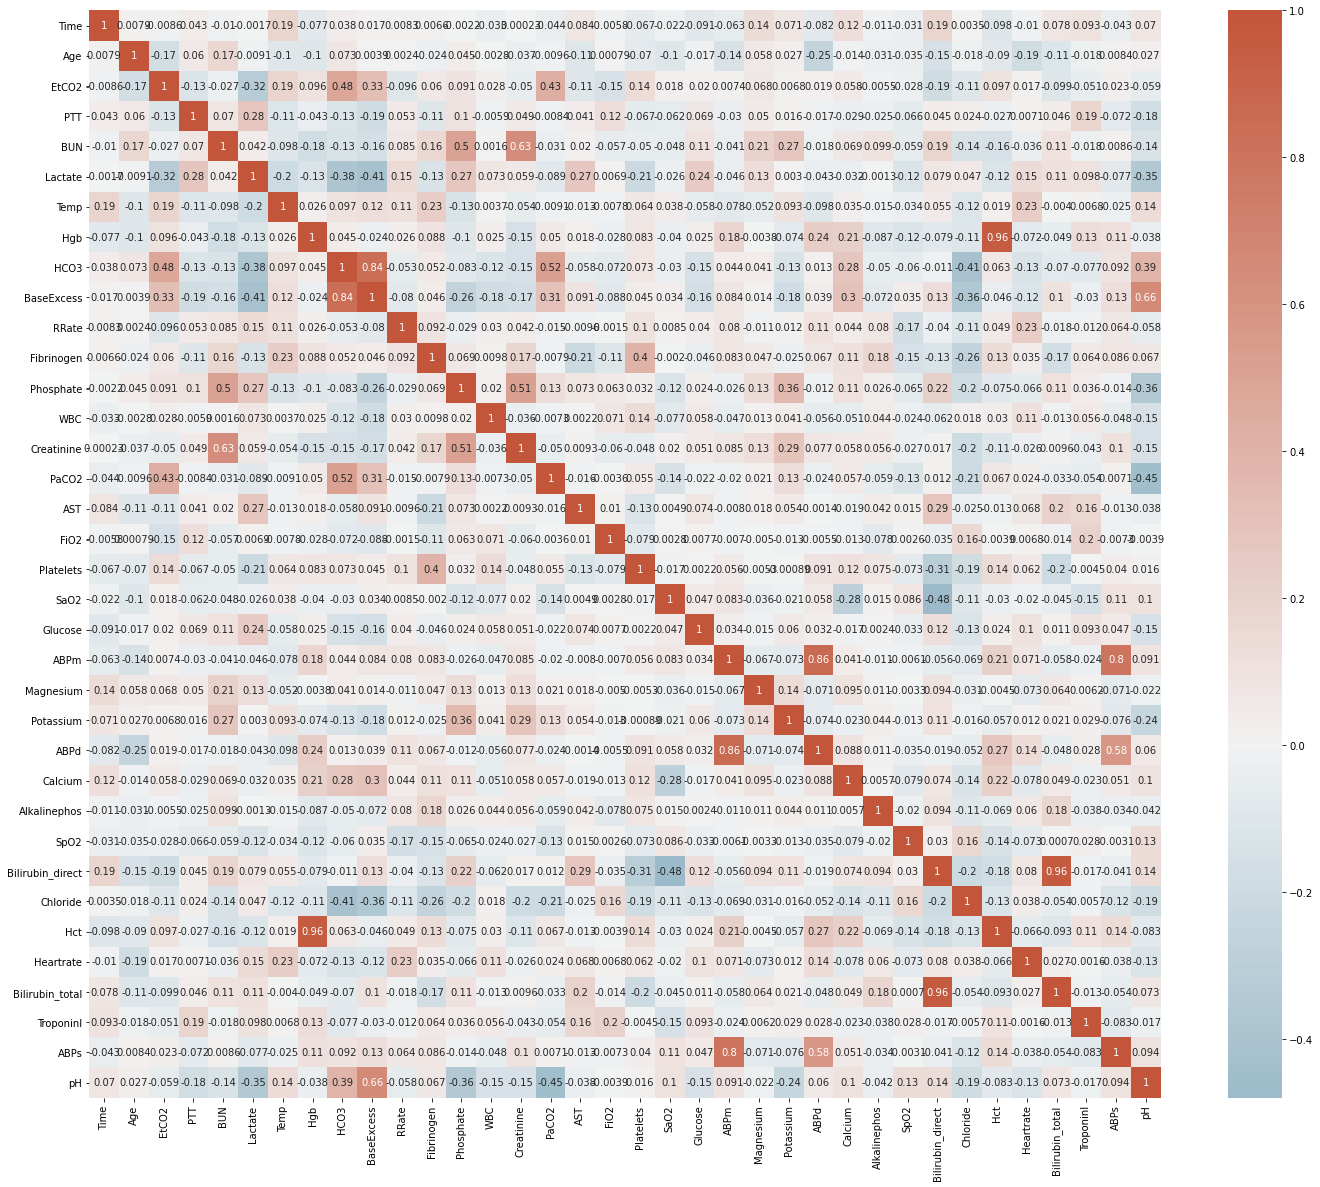

In [13]:
plt.figure(figsize=(24,20))
cor = data_features_train.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(cor, annot=True, cmap=cmap, center=0)
plt.show()

In [28]:
#Correlation with output variable
cor_target = abs(cor["Glucose"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.15]
relevant_features

Lactate       0.244512
HCO3          0.150338
BaseExcess    0.158535
Glucose       1.000000
pH            0.154895
Name: Glucose, dtype: float64

In [ ]:
RRate 0.1: Lactate, SpO2, Heartrate, Temp, Platelets, ABPd, Chloride     

In [ ]:
ABPm 0.1: Age, Hgb, ABPd, Hct, ABPs

In [ ]:
SpO2 0.1: Lactate, Hgb, RRate, Fibrinogen, PaCO2, Chloride, Hct, pH

In [ ]:
Heartrate 0.15: Age, Lactate, Temp, RRate

In [ ]:
['Age','Temp', 'Lactate', 'ABPs', 'Chloride', 'Hgb', 'pH', 'ABPd']